In [1]:
import numpy as np

# Simulate data 

# --- 1. Simulate and Scale Data ---
def simulate_gene_distribution(prob1, prob2, size=10, num_cells=500, seed=42):
    np.random.seed(seed)
    ct1_data = np.random.negative_binomial(size, prob1, num_cells)
    ct2_data = np.random.negative_binomial(size, prob2, num_cells)
    return ct1_data, ct2_data

ct1_data_g1, ct2_data_g1 = simulate_gene_distribution(0.8 , 0.2)
ct1_data_g2, ct2_data_g2 = simulate_gene_distribution(0.4, 0.8)

ct1_data = np.vstack([ct1_data_g1, ct1_data_g2])
ct2_data = np.vstack([ct2_data_g1, ct2_data_g2])

In [10]:
def calculate_cell_percentage(data):
    """Calculates the percentage of cells containing a gene (value > 0).

    Args:
        data: A NumPy array representing gene expression data.

    Returns:
        A NumPy array containing the cell percentages for each gene.
    """
    num_genes = data.shape[0]  # Number of rows (genes)
    num_cells = data.shape[1] # Number of columns (cells)
    percentages = np.zeros(num_genes)  # Initialize an array to store percentages

    for i in range(num_genes):
        positive_cells = np.sum(data[i, :] > 0)  # Count positive cells for gene i
        percentages[i] = positive_cells / num_cells

    return percentages


# Example usage (assuming ct1_data and ct2_data are your data arrays):
ct1_percentages = calculate_cell_percentage(ct1_data)
ct2_percentages = calculate_cell_percentage(ct2_data)

print("CT1 Percentages:", ct1_percentages)
print("CT2 Percentages:", ct2_percentages)


CT1 Percentages: [0.874 1.   ]
CT2 Percentages: [1.    0.882]


In [11]:
# Scale the data
import numpy as np

def scale2pi(data):
    """Scales data from 0-1 to 0-pi."""
    scaled_data = data * np.pi  # Direct scaling since data is already 0-1
    return scaled_data


# Now 'scaled_data' contains values in the range 0 to pi.
# You can then use these values in your P(2.0*x) gates.
# Apply scaling to each gene (row) for both cell types
ct1_percentages = scale2pi(ct1_percentages)  # Scale each gene (row) for ct1_data
ct2_percentages = scale2pi(ct2_percentages)  # Scale each gene (row) for ct2_data

# Display the resulting scaled data
print("Scaled ct1_data:\n", ct1_percentages)
print("Scaled ct2_data:\n", ct2_percentages)

Scaled ct1_data:
 [2.74575198 3.14159265]
Scaled ct2_data:
 [3.14159265 2.77088472]


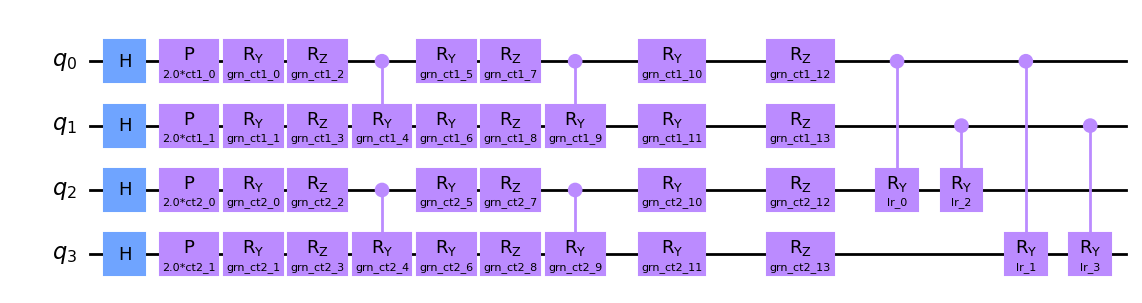

In [12]:
import matplotlib.pyplot as plt
from qiskit.circuit.library import ZFeatureMap, TwoLocal
from qiskit.circuit import QuantumCircuit, Parameter

# --- 2. Quantum Circuit Setup ---
ng_ct1 = 2
ng_ct2 = 2
num_features = ng_ct1 + ng_ct2

feature_map_ct1 = ZFeatureMap(feature_dimension=ng_ct1, reps=1)
feature_map_ct2 = ZFeatureMap(feature_dimension=ng_ct2, reps=1)

ansatz_grn_ct1 = TwoLocal(num_qubits=ng_ct1, rotation_blocks=['ry', 'rz'], entanglement_blocks='cry', entanglement='full', reps=2)
ansatz_grn_ct2 = TwoLocal(num_qubits=ng_ct2, rotation_blocks=['ry', 'rz'], entanglement_blocks='cry', entanglement='full', reps=2)

# Ligand-receptor interaction ansatz (across cell types)
def generate_inter_cell_pairs(ng_ct1, ng_ct2, direction="forward"):
    """Generates pairs of qubits for inter-cell interactions.
    Args:
        ng_ct1: Number of qubits in cell type 1.
        ng_ct2: Number of qubits in cell type 2.
        direction: "forward" for interactions from ct1 to ct2,
                   "backward" for interactions from ct2 to ct1,
    Returns:
        A list of qubit pairs.
    """
    pairs = []
    if direction == "forward":
        for i in range(ng_ct1):
            for j in range(ng_ct2):
                pairs.append([i, j + ng_ct1])
    elif direction == "backward":
        for i in range(ng_ct2):
            for j in range(ng_ct1):
                pairs.append([j + ng_ct2, i])

    else:
        raise ValueError("Invalid direction. Must be 'forward' or 'backward''.")
    return pairs

lr_entanglement = generate_inter_cell_pairs(ng_ct1, ng_ct2, direction="forward")  # Example: Entangle corresponding genes
#lr_entanglement = [[0, 2], [3, 1]]  # Example: Entangle corresponding genes
ansatz_lr = TwoLocal(num_qubits=num_features, entanglement_blocks='cry', entanglement=lr_entanglement, reps=1)

# Parameter Binding (Important!)
theta_ct1 = [Parameter(f"ct1_{i}") for i in range(feature_map_ct1.num_parameters)]
theta_ct2 = [Parameter(f"ct2_{i}") for i in range(feature_map_ct2.num_parameters)]
theta_grn_ct1 = [Parameter(f"grn_ct1_{i}") for i in range(ansatz_grn_ct1.num_parameters)]
theta_grn_ct2 = [Parameter(f"grn_ct2_{i}") for i in range(ansatz_grn_ct2.num_parameters)]
theta_lr = [Parameter(f"lr_{i}") for i in range(ansatz_lr.num_parameters)]

param_dict_ct1 = dict(zip(feature_map_ct1.parameters, theta_ct1))
param_dict_ct2 = dict(zip(feature_map_ct2.parameters, theta_ct2))
param_dict_grn_ct1 = dict(zip(ansatz_grn_ct1.parameters, theta_grn_ct1))
param_dict_grn_ct2 = dict(zip(ansatz_grn_ct2.parameters, theta_grn_ct2))
param_dict_lr = dict(zip(ansatz_lr.parameters, theta_lr))

feature_map_ct1.assign_parameters(param_dict_ct1, inplace=True)
feature_map_ct2.assign_parameters(param_dict_ct2, inplace=True)
ansatz_grn_ct1.assign_parameters(param_dict_grn_ct1, inplace=True)
ansatz_grn_ct2.assign_parameters(param_dict_grn_ct2, inplace=True)
ansatz_lr.assign_parameters(param_dict_lr, inplace=True)

feature_map_ct1_decomposed = feature_map_ct1.decompose()
feature_map_ct2_decomposed = feature_map_ct2.decompose()
ansatz_grn_ct1_decomposed = ansatz_grn_ct1.decompose()
ansatz_grn_ct2_decomposed = ansatz_grn_ct2.decompose()
ansatz_lr_decomposed = ansatz_lr.decompose()

ccgrn_circuit = QuantumCircuit(num_features)
ccgrn_circuit.append(feature_map_ct1_decomposed, [0, 1])
ccgrn_circuit.append(feature_map_ct2_decomposed, [2, 3])
ccgrn_circuit.append(ansatz_grn_ct1_decomposed, [0, 1])
ccgrn_circuit.append(ansatz_grn_ct2_decomposed, [2, 3])
ccgrn_circuit.append(ansatz_lr_decomposed, range(num_features))

# Now you should see the individual gates when you draw the circuit
ccgrn_circuit.decompose().draw(output="mpl", style="clifford", fold=40)

In [13]:
import pandas as pd
from scipy.optimize import minimize
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.primitives import StatevectorEstimator  # Or Estimator if using IBM Runtime

# Optimization section
# --- 3. Interaction Strength ---
interaction_strength_list = []
for pair in lr_entanglement:
    qubit1, qubit2 = pair
    pauli_string = ""
    for i in range(num_features):
        if i == qubit1 or i == qubit2:
            pauli_string += "Z"
        else:
            pauli_string += "I"
    interaction_strength_list.append((pauli_string, -1.0))

# Observable to measure the interaction strength (note: one link per pair, either forward or backward)
interaction_strength = SparsePauliOp.from_list(interaction_strength_list)

# Define cost function ONCE (outside the optimization loop)
def cost_func_vqe(params, combined_ansatz, hamiltonian, estimator):
    """Cost function for VQE (using StatevectorEstimator)"""
    bound_ansatz = combined_ansatz.assign_parameters(params)
    statevector = Statevector(bound_ansatz)  # Get the statevector
    statevector_array = statevector.data  # Convert Statevector to NumPy array

    # Correct way to calculate expectation value:
    hamiltonian_matrix = hamiltonian.to_matrix()
    energy = np.real(statevector_array.conjugate() @ hamiltonian_matrix @ statevector_array)  # Use @ operator
    
    #cost = estimator.run([pub]).result()[0].data.evs
    # or
    # energy = np.real(np.dot(statevector_array.conjugate(), np.dot(hamiltonian_matrix, statevector_array))) #Use numpy.dot

    return energy

def cost_func_wrapper(all_params_values):
    # Update the full parameter dictionary
    for i, param in enumerate(ccgrn_circuit.parameters):
        all_params[param] = all_params_values[i]
    return cost_func_vqe(all_params, ccgrn_circuit, interaction_strength, estimator)

In [18]:
#from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.primitives import StatevectorEstimator
from scipy.optimize import minimize

# Initialize estimator ONCE (outside the optimization loop)
estimator = StatevectorEstimator()
#estimator = Estimator()

interaction_strength = SparsePauliOp.from_list(interaction_strength_list)
print(interaction_strength)  # Should see the interaction strength

# --- Create the FULL parameter dictionary BEFORE optimization ---
# Initialize ALL parameters (including those that were previously "static")\
all_params = dict(zip(
    ccgrn_circuit.parameters,
    np.concatenate([
        ct1_percentages,  # Correct: Select the first element of each row
        ct2_percentages,  # Correct: Select the first element of each row
        np.random.rand(ansatz_grn_ct1.num_parameters + ansatz_grn_ct2.num_parameters + ansatz_lr.num_parameters)
    ])
))

x0_interaction = np.array(list(all_params.values()))  # Initial values for optimization

result_interaction_bfgs = minimize(
    cost_func_wrapper,
    x0_interaction,
    method="BFGS"
)

print(result_interaction_bfgs)

# --- 6. Results and DataFrame ---
optimized_all_parameters = result_interaction_bfgs.x

# Update the all_params dictionary with the optimized values
for i, param in enumerate(ccgrn_circuit.parameters):
    all_params[param] = optimized_all_parameters[i]

df = pd.DataFrame(list(all_params.items()), columns=['Parameter', 'Value'])
df_nonzero = df[abs(df.Value) >= 0.01]
print(df_nonzero)

SparsePauliOp(['ZIZI', 'ZIIZ', 'IZZI', 'IZIZ'],
              coeffs=[-1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j])
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -3.9999999999735287
        x: [ 4.005e+00  4.380e+00 ...  4.189e-01  5.173e-01]
      nit: 22
      jac: [ 5.662e-07 -4.470e-07 ...  0.000e+00  0.000e+00]
 hess_inv: [[ 1.122e+00  2.553e-01 ...  0.000e+00  0.000e+00]
            [ 2.553e-01  8.892e-01 ...  0.000e+00  0.000e+00]
            ...
            [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
            [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
     nfev: 962
     njev: 26
     Parameter     Value
0        ct1_0  4.005321
1        ct1_1  4.380495
2        ct2_0  2.444124
3        ct2_1  2.573754
4    grn_ct1_0  0.995645
5    grn_ct1_1  0.480182
6   grn_ct1_10 -0.458151
7   grn_ct1_11 -0.320757
9   grn_ct1_13  1.486533
10   grn_ct1_2  0.875543
11   grn_ct1_3  0.746757
12   grn_ct1_4 -0.192194
15   grn_ct1_7  0.539823
16  

In [ ]:
estimator = StatevectorEstimator()

# --- Create the FULL parameter dictionary BEFORE optimization ---
static_params = {  # Store the Parameter objects and their values
    feature_map_ct1.parameters[0]: ct1_percentages[0],
    feature_map_ct1.parameters[1]: ct1_percentages[1],
    feature_map_ct2.parameters[0]: ct2_percentages[0],
    feature_map_ct2.parameters[1]: ct2_percentages[1],
}

variable_params = [param for param in ccgrn_circuit.parameters if param not in static_params]

# Initialize variable parameters
x0_interaction = np.random.rand(len(variable_params))

# Create initial full parameter dictionary
full_param_dict = static_params.copy()
full_param_dict.update(dict(zip(variable_params, x0_interaction)))  # Combine with initial variable values

result_interaction_bfgs = minimize(
    cost_func_wrapper,
    x0_interaction,
    method="BFGS"
)
print(result_interaction_bfgs)

# --- 6. Results and DataFrame ---
optimized_variable_parameters = result_interaction_bfgs.x

# Update the full parameter dictionary with optimized variable parameters
for param, value in zip(variable_params, optimized_variable_parameters):
    full_param_dict[param] = value

df = pd.DataFrame(list(full_param_dict.items()), columns=['Parameter', 'Value'])
df_nonzero = df[abs(df.Value) >= 0.01]
print(df_nonzero)

bound_circuit = ccgrn_circuit.copy()
bound_circuit.assign_parameters(full_param_dict, inplace=True)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -3.9999999991426387
        x: [ 3.374e-01  9.304e-01 ... -2.660e-01  2.006e-01]
      nit: 39
      jac: [ 4.172e-07  2.980e-07 ... -8.821e-06  1.788e-07]
 hess_inv: [[ 3.226e+00 -8.464e-02 ...  1.560e+01  2.698e+01]
            [-8.464e-02  7.795e-01 ... -4.901e-01 -8.738e-01]
            ...
            [ 1.560e+01 -4.901e-01 ...  1.026e+02  1.761e+02]
            [ 2.698e+01 -8.738e-01 ...  1.761e+02  3.078e+02]]
     nfev: 1518
     njev: 46
     Parameter     Value
0        ct1_0  2.745752
1        ct1_1  3.141593
2        ct2_0  3.141593
3        ct2_1  2.770885
4    grn_ct1_0  0.337382
5    grn_ct1_1  0.930396
6   grn_ct1_10  0.725696
7   grn_ct1_11  0.014333
8   grn_ct1_12  0.585838
9   grn_ct1_13  0.109550
10   grn_ct1_2  0.543991
11   grn_ct1_3 -0.016557
13   grn_ct1_5  0.644510
14   grn_ct1_6  0.629956
15   grn_ct1_7  0.411852
16   grn_ct1_8  0.761445
18   grn_ct2_0  1.565758
19   grn_c